# **JPEG Image Coding and Compression**

In this notebook, the process of image compression based on Joint Photographic Experts Group (JPEG) is explained. JPEG is a widely used image compression standard developed by the Joint Photographic Experts Group, which is a committee of experts that created the standard in 1992. The JPEG format is used to compress digital images, reducing their file size while maintaining reasonable image quality.

**JPEG Properties and Methods**

JPEG is a lossy compression format, which means that some of the original image data is lost during the compression process. This loss of data can result in a reduction in image quality, but it also makes it possible to significantly reduce the file size of an image.

JPEG allows for variable compression levels, which means that the degree of compression can be adjusted to achieve a balance between image quality and file size. Higher compression levels result in smaller file sizes but lower image quality, while lower compression levels result in larger file sizes but higher image quality.

The basic idea behind JPEG compression is the use of the Discrete Cosine Transform (DCT) to convert the original image from the spatial domain into the frequency domain, followed by quantization and Huffman coding.

Here is a block diagram that illustrates the JPEG compression process [[1]](https://books.google.ca/books/about/Video_Codec_Design.html?id=mjrjCtV9UHgC&source=kp_book_description&redir_esc=y)
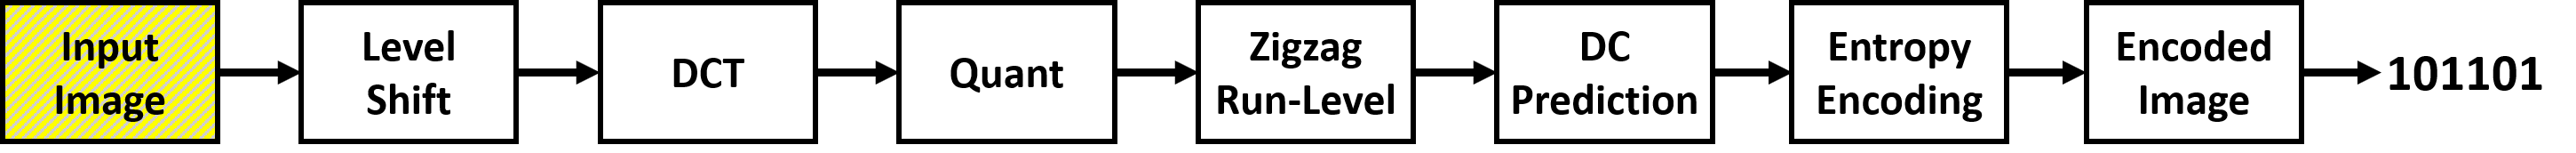

One of the key ideas behind JPEG compression is that the human visual system is less sensitive to higher frequency components of an image than to lower frequency components. It means that we are less likely to perceive small variations in high-frequency components than in low-frequency components.

JPEG takes advantage of this property by discarding the high-frequency components of an image during the compression process. 

# **Importing Required Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from JPEGtools import *

# **Loading Cameraman Image**

Here, for simplicity, we are using the Cameraman figure to demonstrate different stages of JPEG compression. This image has 512x512 pixels and only includes luminance information. Therefore, each pixel has 8 bits with 256 levels representing the luminance of that pixel.

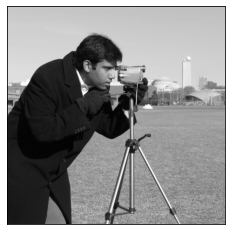

In [2]:
# load the cameraman image
image = data.camera()

# find parameter of this image
height, width = image.shape
Num_bit = 8
levels = 2**8 

# display the image
plt.imshow(image, cmap='gray',)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

# **Discrete Cosine Transform (DCT)**

As we mentioned, the main idea behind JPEG compression is to transform the image into the frequency domain using DCT and to discard high-frequency components. Therefore, we introduce the DCT formula with the following equation [1]

$$F_{x,y}=\frac{C(x)C(y)}{4}\sum_{i=0}^N\sum_{j=0}^Mf_{i,j}\cos(\frac{(2i+1)\pi x}{2M})\cos(\frac{(2j+1)\pi y}{2N}).$$

DCT uses the cosine function as the basis function to decompose the image into these basis functions. $F_{x,y}$ are the coefficients of the DCT corresponding to the index of $x$ and $y$, and $f_{i,j}$ are the pixels. Here, we plot the basis functions for various $x$ and $y$.

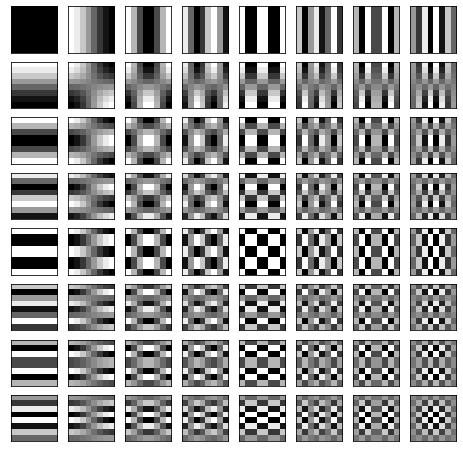

In [3]:
# consider blocks of 8*8
base_func_num = 8

samples  = np.arange(0, base_func_num)
j_samples , i_samples = np.meshgrid(samples, samples)

# display each basis function of DCT
fig, axs = plt.subplots(base_func_num, base_func_num, figsize=(8, 8))
plt.setp(axs, xticks=[], xticklabels=[], yticks=[], yticklabels=[])

for x in range(base_func_num):

    for y in range(base_func_num):

      base_func = np.cos(x*np.pi*(2*i_samples+1)/(2*base_func_num))*np.cos(y*np.pi*(2*j_samples+1)/(2*base_func_num))

      axs[x, y].imshow(base_func, cmap= 'gray')



It is evident that the basis functions display more rapid changes for higher index frequency components, in order to capture high-frequency details in the image.\
This transform is applied to smaller sections of the image named blocks. Here, we divide the image into 8x8 blocks.


# **JPEG Compression and Encoding Steps**

A more detailed steps of JPEG can be seen in the following diagram [[2]](https://books.google.ca/books/about/Standard_Codecs.html?id=7XuU8T3ooOAC&source=kp_book_description&redir_esc=y)
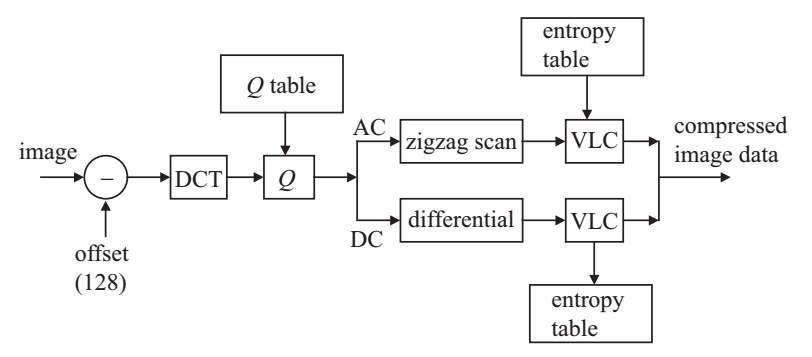

Caption: Block diagram of a baseline JPEG encoder [2]


**Implementation of Steps**

First, a level shift or offset is applied

In [4]:
image_shifted = image -  levels/2 

We also use the following $Q$ table for quantization of DCT components of each 8x8 block in the image [2].

In [5]:
Quantize_mat = np.array([ [16, 11, 10, 16, 24, 40, 51, 61],
                          [12, 12, 14, 19, 26, 58, 60, 55],
                          [14, 13, 16, 24, 40, 57, 69, 56],
                          [14, 17, 22, 29, 51, 87, 80, 62], 
                          [18, 22, 37, 56, 68, 109, 103, 77],
                          [24, 35, 55, 64, 81, 104, 113, 92],
                          [49, 64, 78, 87, 103, 121, 120,101],
                          [72, 92, 95, 98, 112, 100, 103, 99] ]);

For quantization the following formula will be used [2]:
$$F^Q_{x,y} = \lfloor \frac{F_{x,y}}{Q_{x,y}}  \rfloor .$$ 

In the next code blocks, the image is divided into 8x8 blocks. For each block, the difference between the DC component ($F^Q_{0,0}$) of two consecutive blocks is calculated. The other components (AC components) are reformatted into a new sequence using a zigzag pattern, as shown in the following figure.

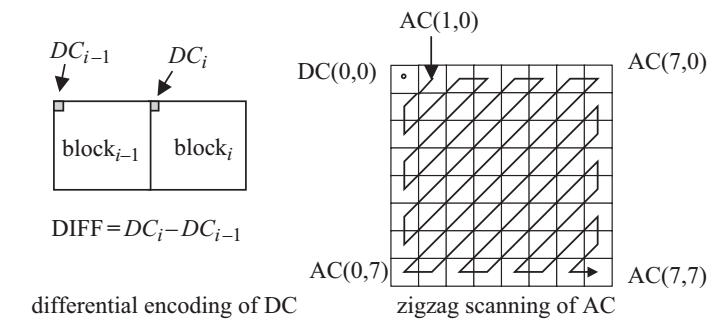

Caption: DC difference of consecutive blocks and zigzag reformatting are performed to prepare the DCT coefficients for entropy coding [2]

Finally, these components are encoded based on Huffman entropy encoding. Here, we used the Huffman coding table in [2] for encoding. The following code block loads the dictionary "codebook.npy", which includes the table.

In [6]:
codebook = np.load("codebook.npy", allow_pickle=True).item()

The following block of code implements the JPEG compression algorithm described above, including dividing the image into 8x8 blocks, performing DCT and quantization, computing DC differences, zigzag reformatting, and Huffman entropy encoding. The dependencies and details of the functions used for each step can be found in the "JPEGtools.py" file.

In [7]:
# ******** Note*********** 
# By increasing the amount of parameter scalar, we can use coarse quantization,
# which results in a more blocky image with fewer details but better compression.
# ************************

# initialize the amount of scaler for compression/quality of output image
scaler = 3

# initialize the size of square block
block_size = 8

# create lists for index of blocks in image
row_list = list(range(0, height, block_size))
col_list = list(range(0, width, block_size))

# initialize the DC_1 and DC parameters of blocks
DC = 0
DC_previous = 0

# create a dictionary for encoded image
encoded_image = {}

# create an array for keeping the reconstructed and compressed image
image_compressed = np.zeros(image_shifted.shape)


# make image into blocks
for i, row_indx in enumerate(row_list):
  for j, col_indx in enumerate(col_list):

    block = image_shifted[row_indx:row_indx + block_size, col_indx:col_indx + block_size]

    # apply 2d DCT to each block
    block_transformed = DCT2(block)

    # quantize frequency coefficient of image
    block_quantized_transformed = np.round(block_transformed/(Quantize_mat*scaler))

    # apply inverse 2d DCT for reconstruction of image
    block_quantized = iDCT2(block_quantized_transformed)

    # keep the reconstructed blocks in the image
    image_compressed[row_indx:row_indx + block_size, col_indx:col_indx + block_size] = block_quantized

    # find the DC component of each block
    DC = block_quantized_transformed[0,0]

    # find the DC difference of currect block and the previous block
    block_quantized_transformed[0,0] = DC - DC_previous
    DC_previous = DC 

    # perform zigzag scan, categorization, and run-category-level coding
    run_level_seq = run_cat_level(block_quantized_transformed)
    
    # perform entropy coding using Huffman encoding tables (dictionary of codebook)
    block_huffman_encoded = block_huffman_encoder(run_level_seq, codebook)
  
    # keep bits of the encoded block in the dictionary
    encoded_image[(i, j)] = block_huffman_encoded

# **Comparison**

Here are the original image and the corresponding reconstructed compressed image, along with their respective entropies and size.

The original image has a resolution of 512 pixels by 512 pixels, with each pixel represented by 1 byte of data.

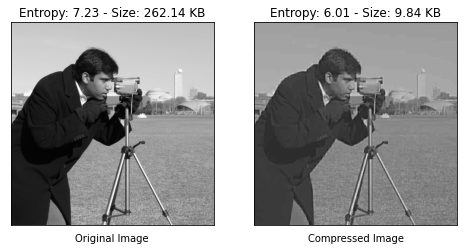

In [8]:
# calculate size of each image in KByte (KB)
size_original = 512*512/1000
size_compressed = size_in_bits(encoded_image)/(8*1000)

# find entropy of images
entrpy_orgnl_image = entropy_2d(image_shifted,levels)
entrpy_comprsd_image = entropy_2d(image_compressed,levels)

# display each basis function of DCT
fig,ax = plt.subplots(1,2,figsize = (8,4))
plt.setp(ax, xticks=[], xticklabels=[], yticks=[], yticklabels=[])

ax[0].imshow(image, cmap = 'gray')
ax[0].set_title('Entropy: {:.2f} - Size: {:.2f} KB'.format(entrpy_orgnl_image, size_original))
ax[0].set_xlabel('Original Image')

ax[1].imshow(image_compressed+levels/2, cmap = 'gray')
ax[1].set_title('Entropy: {:.2f} - Size: {:.2f} KB'.format(entrpy_comprsd_image, size_compressed))
ax[1].set_xlabel('Compressed Image');


By increasing the amount of parameter scalar, we can use coarse quantization, which results in a more blocky image with fewer details but better compression.

# **References**

[[1]](https://books.google.ca/books/about/Video_Codec_Design.html?id=mjrjCtV9UHgC&source=kp_book_description&redir_esc=y)  I. E. Richardson, Video Codec Design: Developing Image and Video Compression Systems. Wiley, 2002.

[[2]](https://books.google.ca/books/about/Standard_Codecs.html?id=7XuU8T3ooOAC&source=kp_book_description&redir_esc=y)	M. Ghanbari and I. o. E. Engineers, Standard Codecs: Image Compression to Advanced Video Coding. Institution of Engineering and Technology, 2003.